# **Identifying identical images using token based fuzzy matching algorithm**

### *- Importing Libraries -*

In [2]:
import os
import cv2
from cv2 import imread, imshow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import itertools

### *- Convert pixels to categorical values -*

In [3]:
def conv_to_cat(n):
    if n<0.5:
        return 'a'
    elif 0.05 <= n < 0.15:
        return 'b'
    elif 0.15 <= n < 0.25:
        return 'c'
    elif 0.25 <= n < 0.35:
        return 'd'
    elif 0.35 <= n < 0.45:
        return 'e'
    elif 0.45 <= n < 0.55:
        return 'f'
    elif 0.55 <= n < 0.65:
        return 'g'
    elif 0.65 <= n < 0.75:
        return 'h'
    elif 0.75 <= n < 0.85:
        return 'i'
    elif 0.85 <= n < 0.95:
        return 'j'
    elif 0.95 <= n < 1:
        return 'k'
    else:
        return 'x'

## Jaccard Similarity 

- The Jaccard Index, also known as the Jaccard similarity coefficient OR Intersection over Union, is a statistic used to identify similarities between given sample sets.

### DESCRIPTION:

- Below function returns an approximate line similarity measure (between 0.0 and 1.0) using tokens (with default token size: q = 2). 


- Tokens are q-character sub-strings contained in a string. For example,

    'anshul' contains the tokens (q=2): ['an','ns','sh','hu','ul].


- Padding will result in specific tokens at the beginning and end of a string, for example 'anshul' converted into padded tokens (q=2) will result in the following token list: ['^a','an','ns','sh','hu','ul','l%'], with '^' illustrating the start and '%' the end character.


- This routine counts the number of common tokens and divides by the average/shortest/longest number of tokens. The resulting number is returned.

### *- Calculating Jaccard similarity -*

In [4]:
QGRAM_START_CHAR = chr(1)

QGRAM_END_CHAR =   chr(2)

def jaccard(str1, str2, q=2, common_divisor = 'longest', min_threshold = None,padded=False):
    if (str1 == '') or (str2 == '') or isinstance(str1, float) or isinstance(str2, float):
        return 0.0
    elif (str1 == str2):
        return 1.0
    
    # Calculate number of q-grams in strings (plus start and end characters) - -
    if (padded == True):
        num_qgram1 = len(str1)+q-1
        num_qgram2 = len(str2)+q-1
    else:
        num_qgram1 = max(len(str1)-(q-1),0)  # Make sure its not negative
        num_qgram2 = max(len(str2)-(q-1),0)
    
    # Check if there are q-grams at all from both strings - - - - - - - - - - - -
    # (no q-grams if length of a string is less than q)
    if ((padded == False) and (min(num_qgram1, num_qgram2) == 0)):
        return 0.0
    
    # Calculate the divisor - - - - - - - - - - - - - - - - - - - - - - - - - - -
    if (common_divisor == 'average'): # Average
        divisor = 0.5*(num_qgram1+num_qgram2) 
    elif (common_divisor == 'shortest'): # Shortest
        divisor = min(num_qgram1,num_qgram2)
    else:  # Longest
        divisor = max(num_qgram1,num_qgram2)
    
    # Use number of q-grams to quickly check for minimum threshold - - - - - - -
    if (min_threshold != None):
        if (isinstance(min_threshold, float)) and (min_threshold > 0.0) and \
           (min_threshold > 0.0):
            
            max_common_qgram = min(num_qgram1,num_qgram2)
            
            w = float(max_common_qgram) / float(divisor)
        
        if (w  < min_threshold):
            return 0.0  # Similariy is smaller than minimum threshold
    
    # Add start and end characters (padding) - - - - - - - - - - - - - - - - - -
    if (padded == True):
        qgram_str1 = (q-1)*QGRAM_START_CHAR+str1+(q-1)*QGRAM_END_CHAR
        qgram_str2 = (q-1)*QGRAM_START_CHAR+str2+(q-1)*QGRAM_END_CHAR
    else:
        qgram_str1 = str1
        qgram_str2 = str2
    
    # Make a list of q-grams for both strings - - - - - - - - - - - - - - - - - -
    qgram_list1 = [qgram_str1[i:i+q] for i in range(len(qgram_str1) - (q-1))]
    qgram_list2 = [qgram_str2[i:i+q] for i in range(len(qgram_str2) - (q-1))]
    
    # Get common q-grams  - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    common = 0
    
    if (num_qgram1 < num_qgram2):  # Count using the shorter q-gram list
        short_qgram_list = qgram_list1
        long_qgram_list =  qgram_list2
    else:
        short_qgram_list = qgram_list2
        long_qgram_list =  qgram_list1
    
    for q_gram in short_qgram_list:
        if (q_gram in long_qgram_list):
            common += 1
            long_qgram_list.remove(q_gram)  # Remove the counted q-gram
    
    w = float(common) / float(divisor)
    
    assert (w >= 0.0) and (w <= 1.0), 'Similarity weight outside 0-1: %f' % (w)
    
    return w

### *- Image preprocessing and convert pixels to string -*


In [5]:
def img_to_str(path, size):
    img = image.load_img(path,target_size=(size,size,3))
    img = image.img_to_array(img)
    img = img/255
    img_to_arr = np.average(img,weights = [0.299,0.587,0.114],axis= 2)
    vec = np.vectorize(conv_to_cat)
    cat_arr = vec(img_to_arr)
    row_arr = [''.join(cat_arr[_,:]) for _ in range(img_to_arr.shape[0])]
    col_arr = [''.join(cat_arr[:,_]) for _ in range(img_to_arr.shape[1])]
    return row_arr + col_arr


### *- Create similarity index for both horizontal and vertical directions -*


In [6]:
def similarity_index(list1,list2,q):
    if len(list1) == len(list2):
        jaccard_dist = [jaccard(list1[i],list2[i],q) for i in range(len(list1))]
    else:
        jaccard_dist = []
    
    if len(jaccard_dist)>0:
        return round(sum(jaccard_dist)/len(jaccard_dist),4)
    else:
        return 0

### *- Filtering images with a helper function -*

In [7]:
def filter_images(images):
    image_list = []
    for image in images:
        try:
            assert imread(image).shape[2] == 3
            image_list.append(image)
        except AssertionError as e:
            print(e)
    return image_list

### *- Create dictionary with the pair of similar images -*

In [8]:
def img_arr_dict(image_list, size):
    ds_dict = {}
    duplicates = []
    for image in image_list:
        match_arr = img_to_str(image, size)

        if image not in ds_dict:
            ds_dict[image] = match_arr
        else:
            duplicates.append((image,ds_dict[image],1))
    return duplicates, ds_dict

### *- Create groups of similar set of images (in case there are more than 2 similar images) -*

In [9]:
def similar_set(duplicates):
    if len(duplicates) > 0:
        dup1 = []
        dup2 = []
        for i in range(len(duplicates)):
            dup1.append((duplicates[i][0],duplicates[i][1]))
            dup1.append((duplicates[i][1],duplicates[i][0]))
            dup2.append(duplicates[i][0])
            dup2.append(duplicates[i][1])
        dup_unique = list(set(dup2))
        set1 = {}
        for i in range(len(dup_unique)):
            set1[i] = [dup_unique[i]]
            for j in range(len(dup1)):
                if dup_unique[i] == dup1[j][0]:
                    set1[i].append(dup1[j][1])
        sim_set = list(set([tuple(set(val)) for val in set1.values()]))
    else:
        sim_set = []
    return sim_set

### *- Main Code -*

In [10]:
Image_dir = '/Users/anshulrankawat/Desktop/test_cases/'
os.chdir(Image_dir)

In [11]:
image_files = os.listdir()
print(len(image_files))

4


In [12]:
image_files = filter_images(image_files)
duplicates, ds_dict = img_arr_dict(image_files,1000)

In [13]:
for k1,k2 in tqdm(itertools.combinations(ds_dict,2)):
    s_index = similarity_index(ds_dict[k1],ds_dict[k2],2)
    if s_index > 0.70:
        duplicates.append((k1,k2,s_index))

6it [01:39, 16.58s/it]


In [14]:
duplicates

[('kohli_coverdrive1.png', 'kohli_coverdrive2.png', 0.9066),
 ('hotel2.png', 'hotel1.png', 0.7471)]

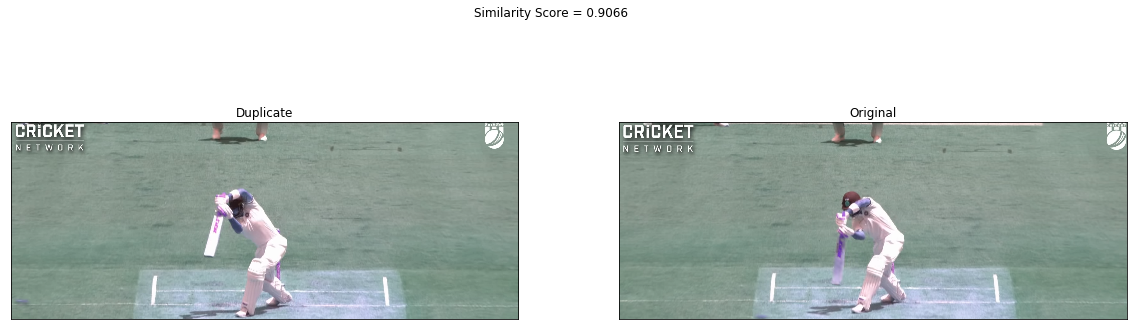

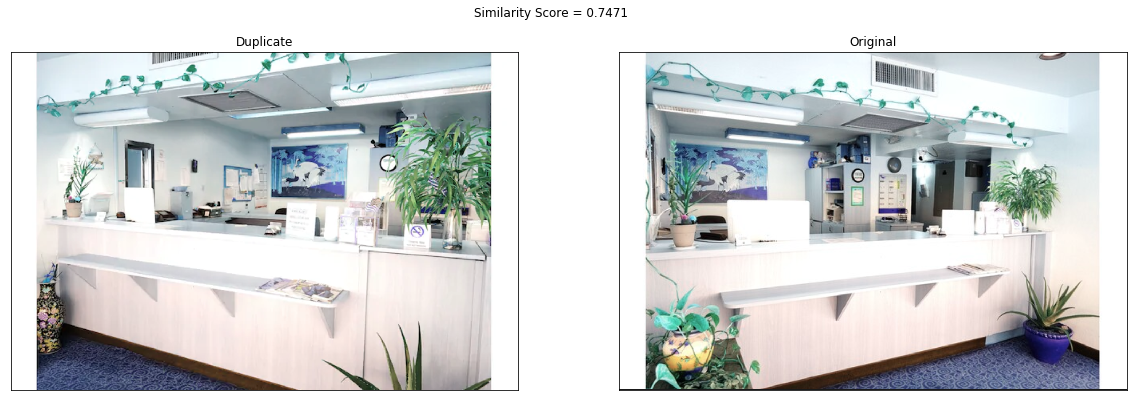

In [15]:
for file_names in duplicates[:len(duplicates)]:
    try:    
        fig = plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(imread(file_names[0]))
        plt.title('Duplicate'), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(file_names[1]))
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        
        fig.suptitle('Similarity Score = {}'.format(file_names[2]), y=0.8)
        plt.show()
    except OSError as e:
        continue

In [16]:
similar_set(duplicates)

[('kohli_coverdrive2.png', 'kohli_coverdrive1.png'),
 ('hotel2.png', 'hotel1.png')]